In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics.pairwise import pairwise_distances

#For plotting
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime

# Import the SimpleExpSmoothing object
from statsmodels.tsa.api import SimpleExpSmoothing

In [2]:
# Get time series data:
data = pd.read_csv('GamesDataAll.csv')

# Make percentile into number and clear "-"
data = data.replace(to_replace='%', value='', regex=True).replace({'-':'NaN'})#.replace(to_replace='Inf', value=+100, regex=True)
#data['Perc_Gain'] = data['Perc_Gain']/100

data.head()

,App_id,Name,Avg_Players,Gain,Perc_Gain,Peak_Players,Last 30 Days,April 2021,March 2021,February 2021,...,April 2013,March 2013,February 2013,January 2013,December 2012,November 2012,October 2012,September 2012,August 2012,July 2012
0,730,Counter-Strike: Global Offensive,1,0,0,0,695044.47,723346.52,740927.82,741013.24,...,16006.0,15959.89,17372.73,16164.22,14079.39,14134.1,10739.48,16000.75,15475.39,932.57
1,730,Counter-Strike: Global Offensive,0,1,0,0,-28302.0,-17581.31,-85.42,-2196.42,...,46.11,-1412.84,1208.51,2084.83,-54.71,3394.62,-5261.27,525.36,14542.81,NaN
2,730,Counter-Strike: Global Offensive,0,0,1,0,-3.91,-2.37,-0.01,-0.30,...,+0.29,-8.13,+7.48,+14.81,-0.39,+31.61,-32.88,+3.39,+1559.43,NaN
3,730,Counter-Strike: Global Offensive,0,0,0,1,1119102,1148077,1198581,1123485,...,31966,32166,35238,31359,27553,50533,20850,36057,52261,1642
4,570,Dota 2,1,0,0,0,413025.27,413784.97,390412.76,404832.13,...,174835.73,180878.9,166972.97,147748.14,121924.42,101077.43,75965.44,61867.68,55768.61,52721.05


In [3]:
# Get Perc_Gain and change data to float.
p_gain = data.loc[data['Perc_Gain']==1]
p_pure = p_gain.drop(columns=['App_id', 'Name', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days']).astype(float)

# Get Gain.
gain = data.loc[data['Gain']==1]
gain_pure = gain.drop(columns=['App_id', 'Name', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days']).astype(float)

# Get Avg_Players.
avg_players = data.loc[data['Avg_Players']==1]
avg_pure = avg_players.drop(columns=['App_id', 'Name', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days']).astype(float)

# Get Peak_Players.
peak_players = data.loc[data['Peak_Players']==1]
peak_pure = peak_players.drop(columns=['App_id', 'Name', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days']).astype(float)

In [4]:
# Prepare for plotting

p_gain_plot = p_gain.drop(columns=['App_id', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days'])
gain_plot= gain.drop(columns=['App_id', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days'])
avg_plot = avg_players.drop(columns=['App_id', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days'])
peak_plot = peak_players.drop(columns=['App_id', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players',
       'Last 30 Days'])

In [5]:
def plot_games(df, games,title=None, scaling=(1e6)):
    
    df_data = df.drop(columns=['Name'])#.reset_index(drop=True)
    x = pd.to_datetime(df.columns[1:])
    plt.figure(figsize=(12,12))
    for i in games:
        plt.plot(x,df_data.iloc[i].astype(float)/scaling,label=df.Name[i])
        plt.legend() 
        plt.title(str(title))
    plt.vlines(pd.Timestamp(2020,3,1)  ,0,1,colors='k',linestyles='dashed',label='Start of Pandemic')
    #plt.text(pd.Timestamp(2020,3,1))
    plt.show()

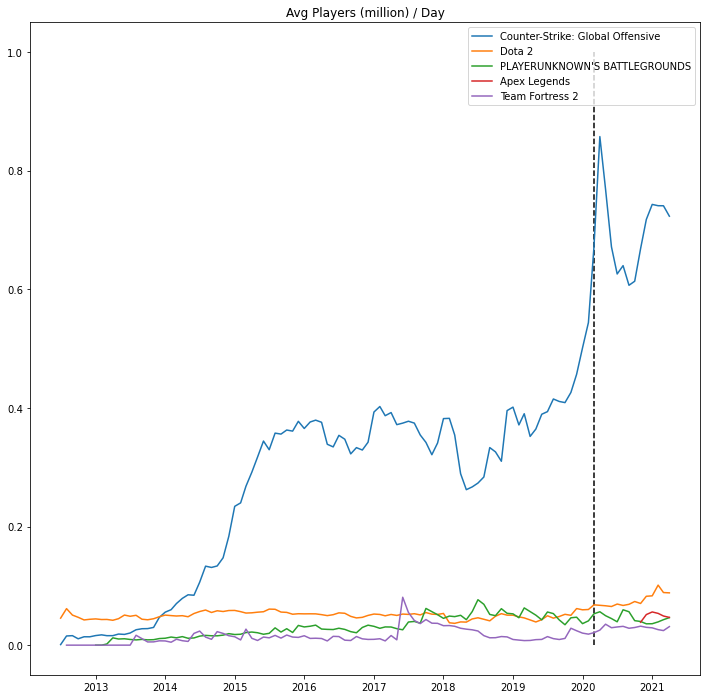

In [6]:
games = avg_players.Name[0:5].index
plot_games(avg_plot,games,title="Avg Players (million) / Day")

In [18]:
# Get data from a single game:
i_game = 0

game_data = avg_plot.drop(columns=['Name']).iloc[i_game]
months = pd.to_datetime(game_data.index)

game = pd.DataFrame({'Month':months,'Avg_Players': game_data.astype(float)}).sort_values(by=['Month'])
game.Month[-5:]

December 2020   2020-12-01
January 2021    2021-01-01
February 2021   2021-02-01
March 2021      2021-03-01
April 2021      2021-04-01
Name: Month, dtype: datetime64[ns]

In [25]:
# Use exponential smoothing to predict the last k months
k=5
test = game[-k:]
train = game.drop(test.index)

ses = SimpleExpSmoothing(train['Avg_Players'].values)
fit = ses.fit(smoothing_level=.2, optimized=False)

C:\Users\zhoul\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


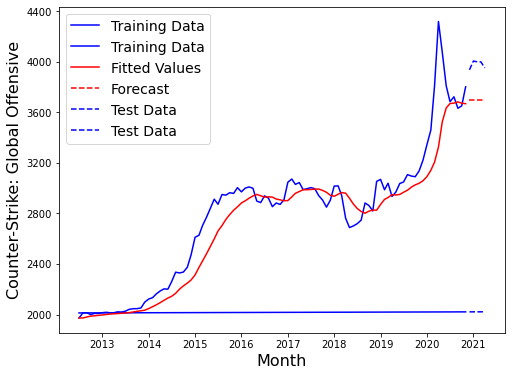

In [26]:
plt.figure(figsize=(8,6))

# plot the training data
plt.plot(game.Month[:106-k],train.values,'b',label = "Training Data")

# plot the fit
plt.plot(game.Month[:106-k],fit.fittedvalues,'r-',label = "Fitted Values")

# plot the forecast
plt.plot(game.Month[-k:],fit.forecast(len(test)),'r--',label = "Forecast")

plt.plot(game.Month[-k:],test.values,'b--',label = "Test Data")

plt.legend(fontsize=14)

plt.xlabel("Month", fontsize=16)
plt.ylabel(str(avg_plot.Name[i_game]), fontsize=16)

plt.show()